In [21]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf

In [22]:
df = pd.read_csv('../data/raw/AAPL.US.csv', parse_dates=['date'])    #asegurar que los datos estan en orden
df = df.sort_values('date').reset_index(drop=True)
df

,date,open,high,low,close,adjusted_close,volume
0,2010-01-04,213.4300,214.4996,212.3800,214.0096,6.4246,493729600
1,2010-01-05,214.6004,215.5888,213.2508,214.3792,6.4357,601904800
2,2010-01-06,214.3792,215.2304,210.7504,210.9688,6.3333,552160000
3,2010-01-07,211.7500,211.9992,209.0508,210.5796,6.3216,477131200
4,2010-01-08,210.2996,211.9992,209.0592,211.9796,6.3637,447610800
...,...,...,...,...,...,...,...
3934,2025-08-25,226.4800,229.3000,226.2300,227.1600,227.1600,30983100
3935,2025-08-26,226.8700,229.4900,224.6900,229.3100,229.3100,54575100
3936,2025-08-27,228.6100,230.9000,228.2600,230.4900,230.4900,31259500
3937,2025-08-28,230.8200,233.4100,229.3400,232.5600,232.5600,38074700


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3939 entries, 0 to 3938
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            3939 non-null   datetime64[ns]
 1   open            3939 non-null   float64       
 2   high            3939 non-null   float64       
 3   low             3939 non-null   float64       
 4   close           3939 non-null   float64       
 5   adjusted_close  3939 non-null   float64       
 6   volume          3939 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 215.5 KB


In [24]:
df.describe()

,date,open,high,low,close,adjusted_close,volume
count,3939,3939.000000,3939.000000,3939.000000,3939.000000,3939.000000,3.939000e+03
mean,2017-10-29 19:10:49.809596416,243.765493,246.165250,241.288264,243.815413,73.603185,2.226692e+08
min,2010-01-04 00:00:00,90.000000,90.700000,89.470000,90.280000,5.765400,2.323470e+07
25%,2013-11-30 12:00:00,141.725000,143.255000,140.265000,141.845000,17.988700,8.050745e+07
50%,2017-10-27 00:00:00,187.840000,189.480000,186.210000,188.020000,37.245100,1.343140e+08
75%,2021-09-27 12:00:00,315.149400,317.724400,311.919600,315.125000,138.997100,2.980182e+08
max,2025-08-29 00:00:00,702.410800,705.070800,699.568800,702.100000,258.103800,1.880998e+09
std,NaN,144.926400,146.175475,143.400581,144.807798,70.755478,2.163075e+08


In [25]:
df.isnull().value_counts()

date   open   high   low    close  adjusted_close  volume
False  False  False  False  False  False           False     3939
Name: count, dtype: int64

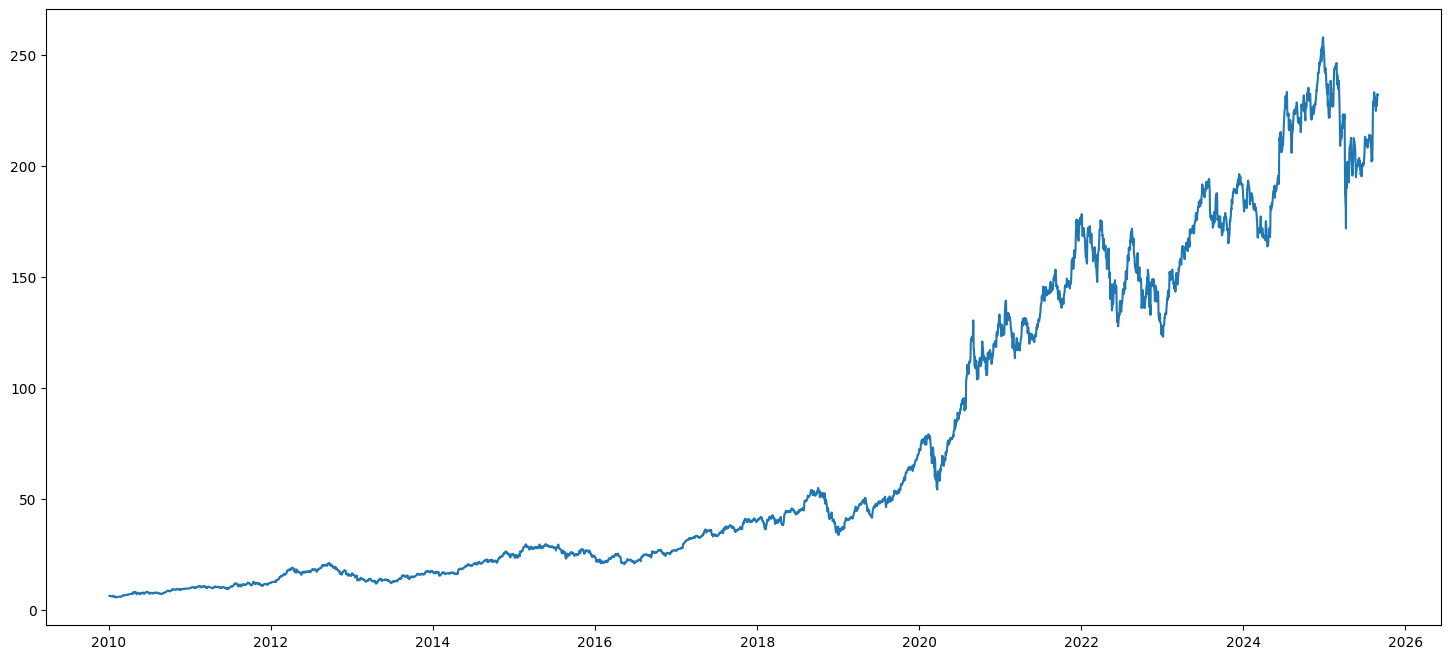

In [26]:
plt.figure(figsize=(18,8))
plt.plot(df["date"], df["adjusted_close"])

### Feature engineering

##### NO ESTACIONARIA

In [27]:
print('p-value:', adfuller(df.adjusted_close)[1])

p-value: 0.9921924713327642


##### ESTACIONARIA

In [28]:
print('p-value:', adfuller(df.adjusted_close.diff(periods = 1).dropna())[1])

p-value: 1.5822511452068332e-21


Vimos que al diferenciar una vez los valores originales, la serie se volvió estacionaria. Pero este proceso también metió algo de ruido en los datos. Para compensarlo, añadimos una nueva variable que ayuda al modelo a explicar esas variaciones extra y, con ello, a entender mejor los patrones reales que hay en la serie.

In [29]:
df["close_diff_1"] = df.adjusted_close.diff(periods=1)

Creamos columnas para apoyar la estacionariedad

In [30]:
df.index = df["date"]
df.drop("date", axis=1, inplace=True)

df.index = pd.to_datetime(df.index)
df = df.copy()
df['dayofweek'] = df.index.dayofweek
df['quarter'] = df.index.quarter
df['month'] = df.index.month
df['year'] = df.index.year
df['dayofyear'] = df.index.dayofyear
df['dayofmonth'] = df.index.day
df['weekofyear'] = df.index.isocalendar().week

##### Autocorrelación parcial (Partial Autocorrelation, PACF)

##### Autocorrelación (ACF)
La **autocorrelación** mide cuánto se parece una serie a sí misma con cierto **retardo (lag)**.  

- Lag 1: relación entre \(y_t\) y \(y_{t-1}\)  
- Lag 2: relación entre \(y_t\) y \(y_{t-2}\)  
- etc.  

Se calcula con la función de autocorrelación (ACF).

---

##### Autocorrelación parcial (PACF)
La **autocorrelación parcial** mide la **relación directa** entre \(y_t\) y \(y_{t-k}\), eliminando la influencia de los lags intermedios.

- **ACF** = relación total (directa + indirecta).  
- **PACF** = relación directa (pura).

---

##### Utilidad en modelos ARIMA
En los modelos ARIMA:  
- La **ACF** ayuda a identificar el orden de la parte **MA (Moving Average)**.  
- La **PACF** ayuda a identificar el orden de la parte **AR (Autoregressive)**.  

Ejemplo:  
- Si la PACF corta en lag 2, puede sugerir un modelo **AR(2)**.  
- Si la ACF corta en lag 1, puede sugerir un modelo **MA(1)**.

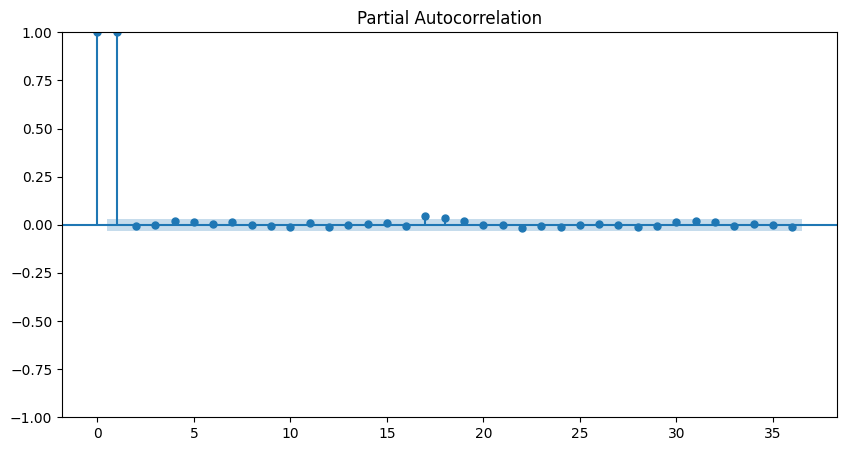

In [31]:
plt.rc("figure", figsize=(10,5))
plot_pacf(df['adjusted_close'], method='ywm')
plt.show()

Los datos muestran una autocorrelación significativa en el lag 1. Por lo tanto, introduciremos una variable que represente el precio lag en 1 periodo.

In [32]:
df["adjusted_close(-1)"] = df['adjusted_close'].shift(1)

Vamos a crear algunos de los indicadores técnicos mas conocidos para analizar las finanzas

In [33]:
df["SMA"] = df["adjusted_close"].rolling(window= 13).mean()

df["EMA"] = df["adjusted_close"].ewm(span=9).mean()

short_EMA = df["adjusted_close"].ewm(span=24).mean()
long_EMA = df["adjusted_close"].ewm(span=52).mean()

df["MACD"] = short_EMA - long_EMA

delta = df["adjusted_close"].diff()
delta = delta[1:]
up = delta.clip(lower=0)
down = -delta.clip(upper=0)
ema_up = up.ewm(com =14-1, min_periods=14).mean()
ema_down = down.ewm(com=14-1, min_periods=14).mean()

df["rsi_14"] = ema_up/ema_down

middle_band = df["adjusted_close"].rolling(window=10).mean()
std_dev = df["adjusted_close"].rolling(window=10).std()

df["Upper_Band"] = middle_band + (std_dev*2)
df["Lower_Band"] = middle_band - (std_dev*2)

``Simple Moving Average (SMA)``: Averages the closing prices over a specified window, smoothing out price fluctuations and highlighting trends.

``Exponential Moving Average (EMA):`` Similar to SMA, EMA gives more weight to recent prices, making it sensitive to short-term price movements.

``Moving Average Convergence Divergence (MACD):`` Represents the difference between short-term EMA and long-term EMA, providing insights into the strength and direction of a trend.

``Relative Strength Index (RSI):`` Measures the speed and change of price movements, indicating overbought or oversold conditions in the market.

Bollinger Bands: Consist of a ``middle band (SMA) and upper/lower bands`` representing price volatility. They help identify price extremes and potential reversal points.

In [34]:
df["H_L_diff"] = df["high"] - df["low"]

In [35]:
df.drop("close", axis=1, inplace=True)
df.drop("high", axis=1, inplace=True)
df.drop("low", axis=1, inplace=True)

In [36]:
df["Bands_diff"] = df["Upper_Band"] - df["Lower_Band"]

In [37]:
df.drop("Upper_Band", axis=1, inplace=True)
df.drop("Lower_Band", axis=1, inplace=True)

In [38]:
df["target"] = df["adjusted_close"].shift(-1)

In [39]:
df.tail()

,open,adjusted_close,volume,close_diff_1,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,adjusted_close(-1),SMA,EMA,MACD,rsi_14,H_L_diff,Bands_diff,target
date,,,,,,,,,,,,,,,,,,,
2025-08-25,226.48,227.16,30983100,-0.60,0,3,8,2025,237,25,35,227.76,228.513892,226.995376,5.836679,1.535379,3.07,11.524136,229.31
2025-08-26,226.87,229.31,54575100,2.15,1,3,8,2025,238,26,35,227.16,229.246923,227.458301,5.938659,1.715462,4.80,11.522352,230.49
2025-08-27,228.61,230.49,31259500,1.18,2,3,8,2025,239,27,35,229.31,229.354615,228.064641,6.060884,1.821901,2.64,10.309129,232.56
2025-08-28,230.82,232.56,38074700,2.07,3,3,8,2025,240,28,35,230.49,229.768462,228.963713,6.238277,2.022982,4.07,10.174094,232.14
2025-08-29,232.51,232.14,39389400,-0.42,4,3,8,2025,241,29,35,232.56,229.960000,229.598970,6.358737,1.937838,2.01,10.431709,NaN
